### Machine Learning Assignment 4 - Logistic Regression
Course code : CMPE-257 
Group name : Seekers 

Members :
           * Anuradha Rajashekar(012409956)
           * Ashwini Shankar Narayan(012506910)
           * Nidhi Jamar(010070593)
           * Sindhu Goudru Shivanandappa Patil(010823683)
           
 ## 1. Data Story
 
The data in the dataset is from a real Czech bank from 1999. The data is about clients and their accounts and has relation account, client, disposiiton,permanent order, transaction, loan, credit card and demographic data. Relations 'loans' and 'credit card' describe some services which bank offers to its clients. More credit cards can be issued to an account but atmost one loan can be granted for an account. The business objective is to analyze the transactional behavior of the customers and predict the loan approval status for the same customers.This is useful in cases where credit card companies provide pre approved loans for customers based on their payment and other factors. To acheive this, the below mentioned steps are followed,

Data preparation and adding account details - Sindhu Goudru Shivanandappa Patil

Identifying the categorical value from the features in dataset - Nidhi Jamar

Applying Decision Tree Algorithm and Visualization - Anuradha Rajashekar

Drawing Inferences from the Visualization - Ashwini Shankar Narayan


## 2 . Dataset Selection
Dataset Link : https://data.world/lpetrocelli/czech-financial-dataset-real-anonymized-transactions

## 3.  Data Preparation
In data preparation step, we read and preprocess the data to identify and remove invlaid values such as ? or NA. Here, we read and parse all the csv files in the dataset using the pandas dataframe.Pandas provide a unique advantage over other libraries in preprocessing the data by providing inbuilt APIs for all the math operations on selected row/column or full dataset. If there are any invalid values, fill it with the median value of the column.

In [12]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import pydotplus
import collections
from sklearn import tree
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score
from IPython.display import Image

# Read the original CSV files using Pandas
trans_d = pd.read_csv("data/data/trans.csv")
loan_d = pd.read_csv("data/data/loan.csv")
account_d = pd.read_csv("data/data/account.csv")
client_d = pd.read_csv("data/data/client.csv")
disp_d = pd.read_csv("data/data/disp.csv")


/Users/i869419/Environments/sjsuml/lib/python3.6/site-packages/IPython/core/interactiveshell.py:2785: DtypeWarning: Columns (8) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


### Collect the data from multiple CSVs to merge together for an account_id

The loan dataset contains only loan details with accountid. No other information of the client is present in loan dataset. Therefore, we are adding account creation date, account login frequency, date of birth of the client and the district id - loaction of the branch to the loan dataset. The output of this section shows that there are no missing/ invalid values.

In [15]:
_column_date = []
_column_frequency = []
_column_district = []
_column_clientdob =[]
for c in loan_d['account_id']:
    _result = account_d.loc[account_d['account_id'] == c]
    _column_date.append(_result['date'].iloc[0])
    _column_frequency.append(_result['frequency'].iloc[0])
    _column_district.append(_result['district_id'].iloc[0])
    _result = disp_d.loc[disp_d['account_id'] == c]
    _result = client_d.loc[client_d['client_id'] == _result['client_id'].iloc[0]]
    _column_clientdob.append(_result['birth_number'].iloc[0])


### Add extra information about account


In [16]:
loan_d['account_date'] = _column_date
loan_d['account_loginfrequency'] = _column_frequency
loan_d['account_district'] = _column_district
loan_d['client_birthNumber'] = _column_clientdob

### Look for missing data and printing unique value in column 'Status' and 'account_loginfrequency'

In [17]:
missing = loan_d.isna().sum()
print(missing)

_statusUnique = list(loan_d['status'].unique())
_freqUnique = list(loan_d['account_loginfrequency'].unique())
print('Unique values in status :{}'.format(_statusUnique))
print('Unique values in account login frequency :{}'.format(_freqUnique))

loan_id                   0
account_id                0
date                      0
amount                    0
duration                  0
payments                  0
status                    0
account_date              0
account_loginfrequency    0
account_district          0
client_birthNumber        0
dtype: int64
Unique values in status :['B', 'A', 'C', 'D']
Unique values in account login frequency :['POPLATEK TYDNE', 'POPLATEK MESICNE', 'POPLATEK PO OBRATU']


In [18]:
loan_d['status'] = [_statusUnique.index(item) for item in loan_d['status']] 
loan_d['account_loginfrequency'] = [_freqUnique.index(item) for item in loan_d['account_loginfrequency']] 


Replace each of the values in status and account_loginfrequency with their corresponding index. Example: Status B will be placed by 0, Status A replaced by 1 and etc.,

## 4. Identifying a categorical value form one of the columns in our dataset
Here, we are getting to know the possible unique values for status feature in loan dataset and login frequency in account dataset.
The only two features with String values from all the datasets is 'status' from loan and 'account_loginfrequency'. Therefore, we need to convert them to integer values. From the output, we understand 'status' feature has 4 unique values: 'A', 'B', 'C' and 'D', where A stands for contract finished, no problem, B stands for contract finished, loan not payed, C stands for running contract, OK so far and D stands for running contract, client in debt 'account_loginfrequency' - frequency of issuance of statements, has 3 unique values 'POPLATEK TYDNE', 'POPLATEK MESICNE', 'POPLATEK PO OBRATU'
where "POPLATEK TYDNE" stands for monthly issuance "POPLATEK TYDNE" stands for weekly issuance "POPLATEK PO OBRATU" stands for issuance after transaction

Here, we are using index values of these feature tuples to set an integer value. For example, in 'status' feature class B willbe assigned integer value 0.

The model is not able to differentiate between clients who have finished contract and who havenot finished contract clearly beacuse there is no column in loan dataset which says whether the contract is finished or not. Therefore, We are reducing the number of classes to binary i.e two classes by classifying as clients who are paying loan regularly and who are not paying regularly.

In [20]:
# Transform the data in status column to binary, by replacing 0 and 3 as 0, 1 and 2 as 1
_temp = []
for d in loan_d['status']:
    if(d==0 or d==3):
        _temp.append(0)
    else:
        _temp.append(1)
loan_d['binary_status']  = _temp        


## 5. Split the data to 70% training data and 30% test data to train model 

In [22]:
from sklearn.model_selection import train_test_split
cols = list(loan_d.columns)
cols.remove('loan_id')
cols.remove('account_id')
cols.remove('status')
cols.remove('binary_status')
X = loan_d[cols].iloc[ :, 0:].values
Y = loan_d['status']
Y_bin = loan_d['binary_status']
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.3, random_state=0)

X_train_bin, X_test_bin, y_train_bin, y_test_bin = train_test_split(X, Y_bin, test_size=0.3, random_state=0)

## 6. Function definintion to visualize the decision tree

In [7]:
def gettreeImg(clf,columns):
    dot_data = tree.export_graphviz(clf,
                                    feature_names=columns,
                                    out_file=None,
                                    filled=True,
                                    rounded=True)
    graph = pydotplus.graph_from_dot_data(dot_data)
    colors = ('turquoise', 'orange')
    edges = collections.defaultdict(list)

    for edge in graph.get_edge_list():
        edges[edge.get_source()].append(int(edge.get_destination()))

    for edge in edges:
        edges[edge].sort()    
        for i in range(2):
            dest = graph.get_node(str(edges[edge][i]))[0]
            dest.set_fillcolor(colors[i])
    return graph

## 7. DECISION TREE on 'status' feature 


Applying Decision tree classifier on "status" feature. Training data for multiclass classification. Calculated accuracy of the predicted data(y_test, y_pred)

In [23]:
multi_classifier = DecisionTreeClassifier(random_state=0,max_depth=3,criterion='gini')
multi_classifier.fit(X_train,y_train)
y_pred = multi_classifier.predict(X_test)

print(accuracy_score(y_test,y_pred)*100)

84.39024390243902


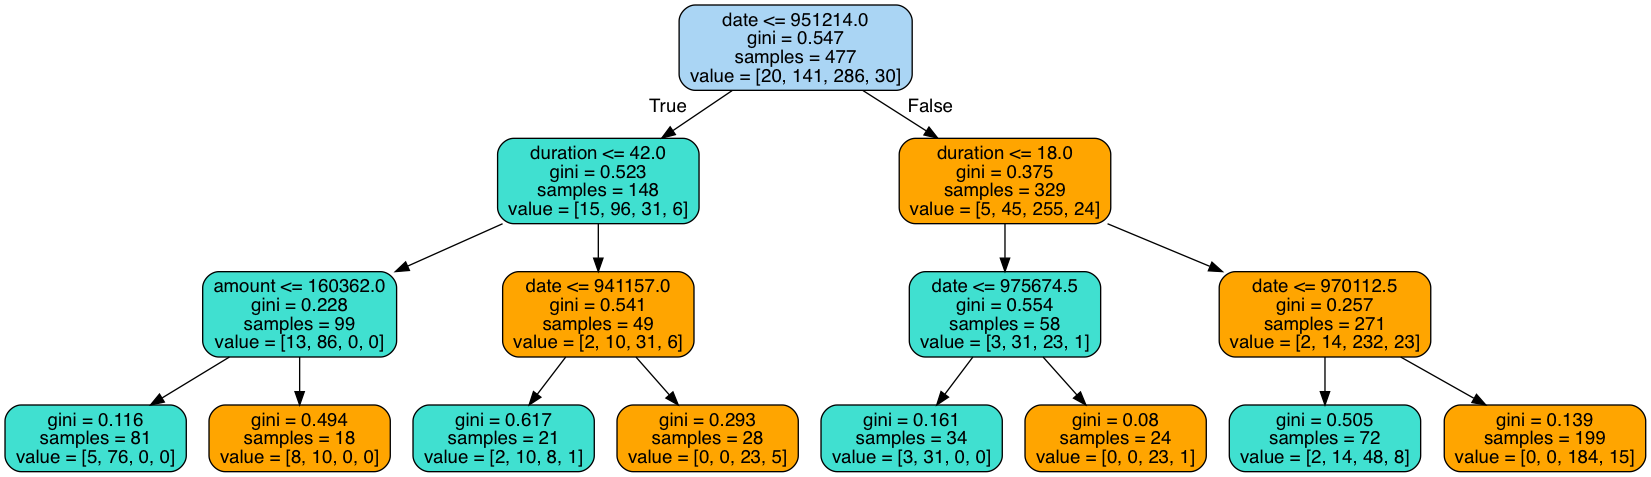

In [24]:
from IPython.display import Image
Image(gettreeImg(multi_classifier,cols).create_png())

## 8. Defining depth for Decision tree and training data for binary classification

Applying Decision tree classifier on "status" feature. Training data for binary classification.After making 'status' feature as binary, the precision increased from 84% to 87% meaning the model is now able to clearly distinguish between clients paying loan regularly and not paying.

In [25]:
binary_classifier = DecisionTreeClassifier(random_state=0,max_depth=3)
binary_classifier.fit(X_train_bin,y_train_bin)
y_pred_bin = binary_classifier.predict(X_test_bin)

print(accuracy_score(y_test_bin,y_pred_bin)*100)

86.34146341463415


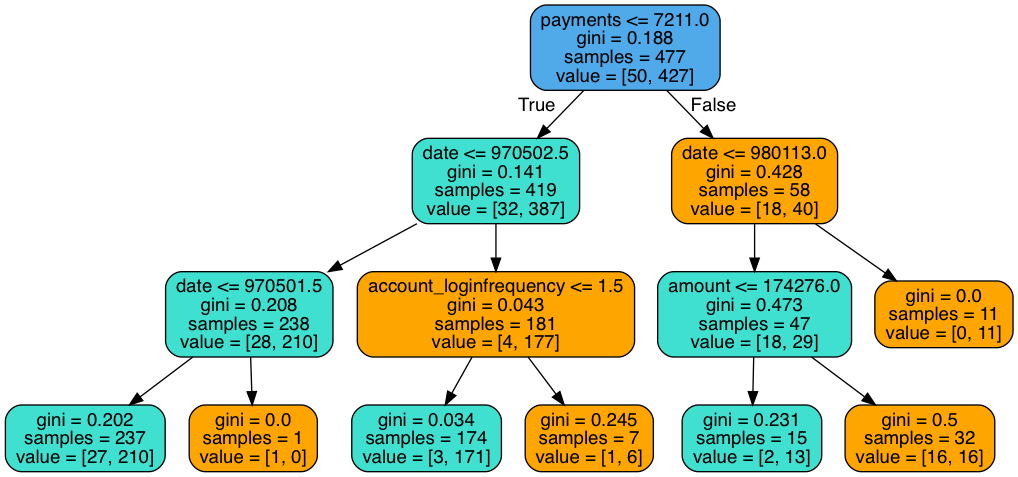

In [27]:
Image(gettreeImg(binary_classifier,cols).create_png())

### Discuss what you are trying to learn from the classification.

In this section, we performed multi class classification and binary classification.  In multi class classification, we are trying to understand if a customer is going to default on a loan , or has already defaulted on a loan. Based on this information, we can understand the customers credit card payment credibality and accordingly offer different promotions.

The binary classification only indicates likelihood of a customers defaulting, irrespective of current loan or completed loans. This  will help us understand the customers ability to payback loans and to be approved for fu
ture loans.
### How does this further develop the story you are telling or discovering about your data set and business problem you are trying to solve?

Along with credit card data we were able to gather data regarding customes and their loan info. The loan data   and other customers information helps us profile them and understand their spending and repayment ability.  And this will further extend our use case to understand the credit card payment reliability and to provide appropriate promotions for such customers.